# Run simulations with different sequencing rules

In [264]:
import os
import sys

current_path = sys.path[0]
sys.path.append(
    current_path[: current_path.find("defi-measurement")]
    + "liquidity-distribution-history"
)

sys.path.append("..")


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from dotenv import load_dotenv
from matplotlib.ticker import MaxNLocator
from pool_state import v3Pool
from sqlalchemy import create_engine

load_dotenv(override=True)


from decimal import getcontext

getcontext().prec = 100  # Set the precision high enough for our purposes


# Read in the environment variables
postgres_uri = os.environ["POSTGRESQL_URI_US"]
blobstorage_uri = os.environ["AZURE_STORAGE_CONNECTION_STRING"]

## Get the swap data

In [46]:
from tqdm import tqdm


def run_simulation(pool: v3Pool, swaps_parameters: list, pbar=True) -> np.ndarray:
    """
    swaps_parameters: list of dicts with the following keys:
        - input: amount of token0 to swap in
        - tokenIn: address of token being swapped in
        - as_of: block number to simulate the swap at
        - gasFee: boolean indicating whether to include gas fees in the swap
    """

    # Get the sqrtPriceX96 at the start of the block
    sqrtPrice_next = pool.getPriceAt(swaps_parameters[0]["as_of"])

    prices = np.zeros(len(swaps_parameters) + 1, dtype=np.float64)

    for i, s in tqdm(enumerate(swaps_parameters, start=0), disable=not pbar):
        s["givenPrice"] = sqrtPrice_next
        _, heur = pool.swapIn(s, fees=True)
        sqrtPrice_next = heur.sqrtP_next
        prices[i] = 1 / (heur.sqrt_P**2 / 1e12)

    # Calculate the price at the end of the block
    prices[-1] = 1 / (sqrtPrice_next**2 / 1e12)

    return prices


In [295]:
# Create the database engine
engine = create_engine(postgres_uri)

# Get a dataframe of blocks that has enough buys and sells
block_number = 13784952
address = "0x3782a3425cd093d5cd0c5b684be72641e199029c"

df1 = pd.read_sql(
    f"""
    SELECT *
    FROM SWAPS
    WHERE BLOCK_NUMBER = {block_number}
        AND ADDRESS = '{address}'
    """,
    engine,
)

df1.head()

,block_ts,block_number,tx_hash,log_index,sender,recipient,amount0,amount1,sqrtpricex96,liquidity,tick,address,to_address,from_address,transaction_index
0,2021-12-11 16:33:56,13784952,0x5fe02584f2515cb0cc10066c87aea57a0846d47e3fbc...,463,0xe592427a0aece92de3edee1f18e0157c05861564,0xaaba208f1d917bddd54fda08ddcc6a0c297b9f01,-10552291106201774762,450000000000000000,16284768737774070722354020306,3106892032541987742925,-31644,0x3782a3425cd093d5cd0c5b684be72641e199029c,0xaaba208f1d917bddd54fda08ddcc6a0c297b9f01,0xe592427a0aece92de3edee1f18e0157c05861564,290
1,2021-12-11 16:33:56,13784952,0xe869611418c7dd56f60afbb3d3f5a14ce96f76a3b603...,97,0xe592427a0aece92de3edee1f18e0157c05861564,0x4f3215bb59dbd3a868510ebc02971570778aa360,-1000000000000000000,42227500776102749,16199781642085336072346329602,3106892032541987742925,-31749,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x4f3215bb59dbd3a868510ebc02971570778aa360,0xe592427a0aece92de3edee1f18e0157c05861564,118
2,2021-12-11 16:33:56,13784952,0x8ce5960f53d64c529f6875db01292ffcd054fd01aa68...,468,0xe592427a0aece92de3edee1f18e0157c05861564,0x06544ac8b449a6ce511aae1498a6fdd4334ee3c2,-3000000000000000000,128049028249077473,16288001434057853376159324977,3106892032541987742925,-31640,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x06544ac8b449a6ce511aae1498a6fdd4334ee3c2,0xe592427a0aece92de3edee1f18e0157c05861564,292
3,2021-12-11 16:33:56,13784952,0xbbc8a6754c136a494fcd78e5350a87933e6baf0dacba...,224,0xe592427a0aece92de3edee1f18e0157c05861564,0x5f2858be2be8e8684b5c2b837a7d2fb4e8b19c54,-11776528852187460675,500000000000000000,16249585274264516504641176693,3106892032541987742925,-31687,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x5f2858be2be8e8684b5c2b837a7d2fb4e8b19c54,0xe592427a0aece92de3edee1f18e0157c05861564,180
4,2021-12-11 16:33:56,13784952,0xd834165e31de354f0a8d7b55e8f487cd1cf444e803d4...,650,0xe592427a0aece92de3edee1f18e0157c05861564,0xe592427a0aece92de3edee1f18e0157c05861564,1645980167786193220,-68795375273346274,16278182313508629180236454666,3106892032541987742925,-31652,0x3782a3425cd093d5cd0c5b684be72641e199029c,0x3181955d2646998f7150065e2a48823d78123928,0xe592427a0aece92de3edee1f18e0157c05861564,382


In [296]:
# Query the `token_info` table to get the token symbols
token_info = pd.read_sql(
    f"""
    SELECT *
    FROM TOKEN_INFO
    WHERE pool = '{address}'
    """,
    engine,
)

pool_name = f"{token_info['token0symbol'][0]}-{token_info['token1symbol'][0]}-{int(token_info['fee'][0]) / 1e4}%" # type: ignore
pool_name

'BYTES-WETH-1.0%'

In [297]:
df2 = pd.read_gbq(
    """
    SELECT * FROM `bigquery-public-data.crypto_ethereum.transactions`
    WHERE `block_number` = 13784918
    """,
    project_id="mimetic-design-338620",
    dialect="standard",
)

df2.shape

(404, 21)

In [298]:
df2.head()

,hash,nonce,transaction_index,from_address,to_address,value,gas,gas_price,input,receipt_cumulative_gas_used,...,receipt_contract_address,receipt_root,receipt_status,block_timestamp,block_number,block_hash,max_fee_per_gas,max_priority_fee_per_gas,transaction_type,receipt_effective_gas_price
0,0x69d5a3e56630c0455c5fc59e77d0a1edc6b5970c2eca...,87524,185,0x86d3e894b5cdb6a80afffd35ed348868fb98dd3f,0x3f9e50723fc2dbc6aa28d95a92187f1b3c01ce96,28056863173000000.000000000,100000,237776181098,0x,14007342,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,272408296958,1621499999,2,237776181098
1,0x59aed716a970819cef3a86b7ecb31a84432ea3cd3c2b...,2770912,62,0x2faf487a4414fe77e2327f0bf4ae2a264a776ad2,0x0000000000085d4780b73119b644ae5ecd22b376,0E-9,92839,263919681099,0xa9059cbb000000000000000000000000e80f6995ecf6...,5495793,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,1000000000000,27765000000,2,263919681099
2,0xeb6e2efd3824c337f453cda2ca0c61732d3ab239c545...,973740,75,0xc098b2a3aa256d2140208c3de6543aaef5cd3a94,0xfb934067c8b9cae42f3b296fe977409b4f8e1435,2435226000000000000.000000000,63000,255534681099,0x,6010927,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,1000000000000,19380000000,2,255534681099
3,0x54bdd731bdecc7f9f3b8b62b84ba552098b73ee0b422...,5,49,0x2e26a00c1cd0d2e55975dfb3d274aeb24c79a074,0x3f7194a830526c0f3bad0ba0936539cab5c5e8c1,483414663807134480.000000000,21000,284060135956,0x,4707313,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,284060135956,284060135956,2,284060135956
4,0xaf63abd13021f31aa8b4ee355e349d5611801d6abf34...,26,88,0xf1ef421ee13b66ca7636f2a4d14435fd1b395dfc,0x698fbaaca64944376e2cdc4cad86eaa91362cf54,0E-9,82321,246154681099,0xd0d2a9e8000000000000000000000000000000000000...,6678982,...,None,None,1,2021-12-11 16:25:20+00:00,13784918,0x4f957d4673c55a9ba044c3d68883aa077bc0d8ba13f4...,258737480195,10000000000,2,246154681099


In [299]:
# Join the two dataframes on the `tx_hash` in df and the `hash` in df2
df = df1.merge(df2, left_on="tx_hash", right_on="hash", how="left", suffixes=("", "_y"))

df.columns

Index(['block_ts', 'block_number', 'tx_hash', 'log_index', 'sender',
       'recipient', 'amount0', 'amount1', 'sqrtpricex96', 'liquidity', 'tick',
       'address', 'to_address', 'from_address', 'transaction_index', 'hash',
       'nonce', 'transaction_index_y', 'from_address_y', 'to_address_y',
       'value', 'gas', 'gas_price', 'input', 'receipt_cumulative_gas_used',
       'receipt_gas_used', 'receipt_contract_address', 'receipt_root',
       'receipt_status', 'block_timestamp', 'block_number_y', 'block_hash',
       'max_fee_per_gas', 'max_priority_fee_per_gas', 'transaction_type',
       'receipt_effective_gas_price'],
      dtype='object')

In [300]:
# Keep only the columns we need
df = df[
    [
        "block_number",
        "tx_hash",
        "transaction_index",
        "log_index",
        "sender",
        "amount0",
        "amount1",
        "gas_price",
    ]
].set_index(["transaction_index", "log_index"])

df.head()

,,block_number,tx_hash,sender,amount0,amount1,gas_price
transaction_index,log_index,,,,,,
290,463,13784952,0x5fe02584f2515cb0cc10066c87aea57a0846d47e3fbc...,0xe592427a0aece92de3edee1f18e0157c05861564,-10552291106201774762,450000000000000000,<NA>
118,97,13784952,0xe869611418c7dd56f60afbb3d3f5a14ce96f76a3b603...,0xe592427a0aece92de3edee1f18e0157c05861564,-1000000000000000000,42227500776102749,<NA>
292,468,13784952,0x8ce5960f53d64c529f6875db01292ffcd054fd01aa68...,0xe592427a0aece92de3edee1f18e0157c05861564,-3000000000000000000,128049028249077473,<NA>
180,224,13784952,0xbbc8a6754c136a494fcd78e5350a87933e6baf0dacba...,0xe592427a0aece92de3edee1f18e0157c05861564,-11776528852187460675,500000000000000000,<NA>
382,650,13784952,0xd834165e31de354f0a8d7b55e8f487cd1cf444e803d4...,0xe592427a0aece92de3edee1f18e0157c05861564,1645980167786193220,-68795375273346274,<NA>


In [301]:
# Convert amount0 and amount1 to floats
df["amount0"] = df["amount0"].astype(float)
df["amount1"] = df["amount1"].astype(float)

# Convert gas_price to float
df["gas_price"] = df["gas_price"].astype(float)

# Add column for buy/sell
df["direction"] = np.where(df.amount0 > 0, "buy", "sell") # type: ignore

df.head()   

,,block_number,tx_hash,sender,amount0,amount1,gas_price,direction
transaction_index,log_index,,,,,,,
290,463,13784952,0x5fe02584f2515cb0cc10066c87aea57a0846d47e3fbc...,0xe592427a0aece92de3edee1f18e0157c05861564,-1.055229e+19,4.500000e+17,NaN,sell
118,97,13784952,0xe869611418c7dd56f60afbb3d3f5a14ce96f76a3b603...,0xe592427a0aece92de3edee1f18e0157c05861564,-1.000000e+18,4.222750e+16,NaN,sell
292,468,13784952,0x8ce5960f53d64c529f6875db01292ffcd054fd01aa68...,0xe592427a0aece92de3edee1f18e0157c05861564,-3.000000e+18,1.280490e+17,NaN,sell
180,224,13784952,0xbbc8a6754c136a494fcd78e5350a87933e6baf0dacba...,0xe592427a0aece92de3edee1f18e0157c05861564,-1.177653e+19,5.000000e+17,NaN,sell
382,650,13784952,0xd834165e31de354f0a8d7b55e8f487cd1cf444e803d4...,0xe592427a0aece92de3edee1f18e0157c05861564,1.645980e+18,-6.879538e+16,NaN,buy


In [302]:
# Create pool object
from experiments.random_permutations import load_pool


pool = load_pool(
    pool_address=address,
    postgres_uri=postgres_uri,
)

Loading pool from cache


## Define functions for sequencing and plotting

In [303]:
def run_sequence(pool: v3Pool, df: pd.DataFrame, senders_dict: dict, ax=None) -> tuple[pd.DataFrame, list, list]:

    # Run the baseline simulation
    swaps_parameters = [
        {
            "input": row["amount0"],
            "tokenIn": pool.token0,
            "as_of": row["block_number"],
            "gasFee": True,
        }
        for _, row in df.iterrows()
    ]

    prices = run_simulation(pool, swaps_parameters)

    # Plot the prices
    # x-ticks for every swap
    if ax is None:
        _, ax = plt.subplots(figsize=(16, 8))

    ax.plot(range(len(prices)), prices, label="Price")
    ax.set_title("Price Curve within a Block")
    ax.set_xlabel("Swap Number")
    ax.set_ylabel("Price")
    ax.grid()

    # Have tick labels for every swap
    ax.xaxis.set_major_locator(MaxNLocator(integer=True, nbins=len(prices)))
    ax.set_xlim(0, len(prices) - 1)

    # Add labels for buy/sell
    for i, row in df.reset_index(drop=True).iterrows():
        if row["direction"] == "buy":
            ax.axvline(i, color="green", alpha=0.3) # type: ignore
        else:
            ax.axvline(i, color="red", alpha=0.3) # type: ignore

    # Add labels sender
    for i, row in df.reset_index(drop=True).iterrows():
        ax.text(
            i, # type: ignore
            prices[i], # type: ignore
            senders_dict[row["sender"]],
            rotation=0,
            verticalalignment="bottom",
            horizontalalignment="left",
            fontsize=14,
            alpha=0.75,
        )

    # Add a horzonital line at the initial price
    ax.axhline(prices[0], color="purple", alpha=0.75, label="Initial Price", ls="--")

    # Add the transaction sizes as a bar chart on the bottom of the plot
    ax2 = ax.twinx()
    ax2.bar(
        range(len(prices) - 1),
        df["amount0"].abs(),
        color="black",
        alpha=0.3,
        width=0.5,
        align="edge",
        label="Swap Size",
    )
    ax2.set_ylabel("Transaction Size", color="black")
    ax2.set_ylim(0, 2 * df["amount0"].abs().max().item())

    # Calculate the absolute area between the price curve and the initial price
    area = np.trapz(np.abs(prices - prices[0]))

    # Shade in the area between the initial price and the price curve
    ax.fill_between(
        range(len(prices)),
        prices[0],
        prices,
        where=prices > prices[0],
        facecolor="green",
        alpha=0.1,
        interpolate=True,
        label=f"Area: {area:.2e}",        
    )
    ax.fill_between(
        range(len(prices)),
        prices[0],
        prices,
        where=prices < prices[0],
        facecolor="green",
        alpha=0.1,
        interpolate=True,
    )

    # Add a line for the maximum deviation from the initial price in absolute terms
    max_dev = prices[np.argmax(np.abs(prices - prices[0]))]
    ax.axhline(
        max_dev,
        color="black",
        alpha=0.75,
        label=f"Max Deviation: {(max_dev - prices[0]) / prices[0]:.2%}",
        ls="--",
    )

    # Add the relative standard deviation of the price in the legend
    ax.axhline(
        prices.std() + prices[0],
        color="red",
        alpha=0.75,
        label=f"Std Dev: {prices.std() / prices.mean():.2%}",
        ls="-.",
    )

    # Add a legend in the plot in the top right
    # fig.legend(loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    # Combine the legend handles from the two axes
    handles, labels = ax.get_legend_handles_labels()
    handles2, labels2 = ax2.get_legend_handles_labels()
    handles.extend(handles2)
    labels.extend(labels2)

    # Set the new handles and labels on the original axis object
    ax.legend(handles, labels, loc="upper right", bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes)

    # Return a dataframe with the realized prices with the same index as df
    return pd.DataFrame(dict(prices=prices[1:], direction=df.direction), index=df.index), handles, labels

In [304]:
def make_senders_dict(df: pd.DataFrame) -> dict:
    senders = df.sender.unique()
    return {s: chr(65 + i) for i, s in enumerate(senders)}

In [305]:
from collections import deque


def sequencing_by_rule(df: pd.DataFrame) -> pd.DataFrame:
    delta_amount0 = 0
    sequence = []

    # Order by the gas price descending
    df = df.sort_values("gas_price", ascending=False)

    # Split into buys and sells
    buy_q = deque(df[df.direction == "buy"].index)
    sell_q = deque(df[df.direction == "sell"].index)

    # Add the buys and sells according to the rule
    while buy_q and sell_q:
        if delta_amount0 > 0:
            # Sell
            sequence.append(sell_q.popleft())
            delta_amount0 += df.loc[sequence[-1], "amount0"]
        else:
            # Buy
            sequence.append(buy_q.popleft())
            delta_amount0 += df.loc[sequence[-1], "amount0"]

    # Add the remaining buys and sells
    sequence.extend(list(buy_q) + list(sell_q))

    # Return the dataframe with the realized prices
    return df.loc[sequence]
    
sequenced_df = sequencing_by_rule(df)

## Compare original sequence with an implementation of the sequencing rule


0it [00:00, ?it/s]

4it [00:00, 38.91it/s]

Initializing liquidity


32it [00:00, 62.62it/s]
32it [00:00, 65.78it/s]


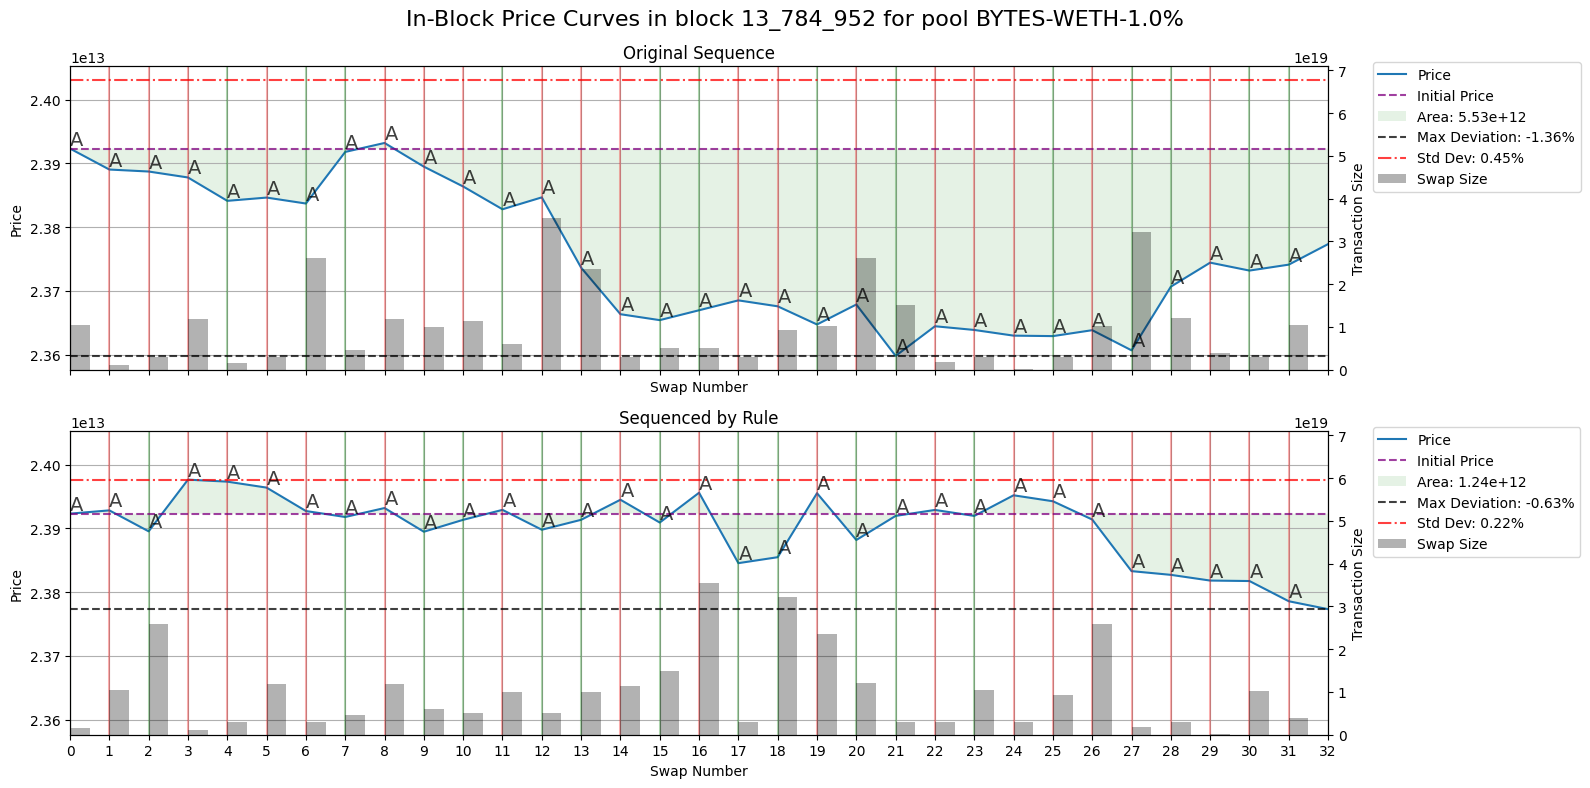

In [306]:
def compare_with_sequencing_rule(df: pd.DataFrame, pool: v3Pool) -> tuple[pd.DataFrame, pd.DataFrame, dict]:
    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), sharex=True, sharey=True)

    senders_dict = make_senders_dict(df)

    original_prices, handles1, labels1 = run_sequence(pool, df, senders_dict, ax=ax1)
    sequenced_prices, handles2, labels2 = run_sequence(pool, sequenced_df, senders_dict, ax=ax2)

    ax1.set_title("Original Sequence")
    ax2.set_title("Sequenced by Rule")


    # Place the legend underneath the plot laid out horizontally
    ax1.legend(
        handles1,
        labels1,
        loc="center left",
        bbox_to_anchor=(1.03, 0.8),
        ncol=1
    )

    # Place the legend underneath the plot laid out horizontally
    ax2.legend(
        handles2,
        labels2,
        loc="center left",
        bbox_to_anchor=(1.03, 0.8),
        ncol=1
    )

    # Set the super title
    fig.suptitle(f"In-Block Price Curves in block {block_number:_} for pool {pool_name}", fontsize=16)

    fig.tight_layout()

    return original_prices, sequenced_prices, senders_dict

original_prices, sequenced_prices, senders_dict = compare_with_sequencing_rule(df, pool)

## Calculate the difference in price for each swap

In [307]:
def get_welfare_change(original: pd.DataFrame, sequenced: pd.DataFrame) -> pd.DataFrame:
    diff_df = pd.concat(
        [
            original.rename(columns={"prices": "actual"}).drop(columns="direction"),
            sequenced.rename(columns={"prices": "sequenced"}),
        ],
        axis=1,
    )

    df_diff = diff_df.assign(directional_diff=np.where(df.direction.values == "sell", (diff_df.sequenced - diff_df.actual).values, diff_df.actual - diff_df.sequenced)) # type: ignore
    df_diff = df_diff.assign(relative_diff=df_diff.directional_diff / df_diff.actual) # type: ignore

    # Join with the senders from the original dataframe
    df_diff = df_diff.join(df.sender)
    df_diff.sender = df_diff.sender.map(senders_dict)

    return df_diff

df_diff = get_welfare_change(original_prices, sequenced_prices)

df_diff.head()

,,actual,sequenced,direction,directional_diff,relative_diff,sender
transaction_index,log_index,,,,,,
290,463,2.389037e+13,2.389549e+13,sell,5.127413e+09,0.000215,A
118,97,2.388725e+13,2.397344e+13,sell,8.618771e+10,0.003608,A
292,468,2.387791e+13,2.396408e+13,sell,8.617086e+10,0.003609,A
180,224,2.384125e+13,2.392735e+13,sell,8.610475e+10,0.003612,A
382,650,2.384637e+13,2.392838e+13,buy,-8.200767e+10,-0.003439,A


## Compare the welfare of the traders

/var/folders/wz/m18d0_fs3bn6b22tw0x4gsk00000gn/T/ipykernel_58710/3945527388.py:34: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set_ylim(1.2*min(trader_diff['directional_diff']), 1.2*max(trader_diff['directional_diff']))  # add some padding above and below the max/min values


,directional_diff,relative_diff
sender,,
A,3.273144e+11,0.013918
Total,3.273144e+11,0.013918


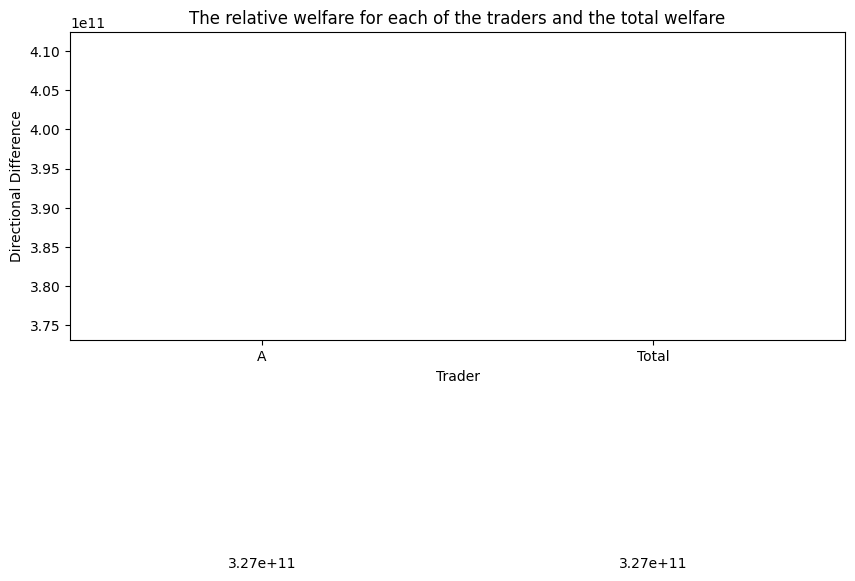

In [308]:
def plot_traders_welfare(df_diff: pd.DataFrame) -> pd.DataFrame:

    # Aggregate the difference by sender and add a total row
    trader_diff = df_diff.groupby("sender").agg(
        {
            "directional_diff": "sum",
            "relative_diff": "sum",
        }
    )

    trader_diff.loc["Total"] = trader_diff.sum()


    # create a color list, using green for positive values and red for negative
    colors = ['g' if (x > 0) else 'r' for x in trader_diff['directional_diff']]
    colors[-1] = 'gray'  # assuming 'Total' is the last row


    fig, ax = plt.subplots(figsize=(10, 4))

    # create the bar plot
    bars = ax.bar(trader_diff.index, trader_diff['directional_diff'], color=colors)

    # add data labels
    for bar in bars:
        yval = bar.get_height()
        yval_sci = f"{yval:.2e}"

        if yval > 0:
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, yval_sci, ha='center', va='bottom')
        else:
            ax.text(bar.get_x() + bar.get_width()/2, yval + 0.05*yval, yval_sci, ha='center', va='top')

    ax.set_ylim(1.2*min(trader_diff['directional_diff']), 1.2*max(trader_diff['directional_diff']))  # add some padding above and below the max/min values

    # add title and labels
    plt.title('The relative welfare for each of the traders and the total welfare')
    plt.xlabel('Trader')
    plt.ylabel('Directional Difference')

    return trader_diff

trader_diff = plot_traders_welfare(df_diff)

trader_diff.head()